In [2]:
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
import pandas as pd
import xarray 
import rioxarray

import rasterio
import fiona
import rasterio.mask

from geopandas.tools import overlay

# DATA

In [31]:
#SAVE AS RASTER

pays = 'france'
resolution   = '9km'
xds = xarray.open_dataset('C:\\Users\\Basile\\Pictures\\JOBS\\INSIGTH\\Weather\\adaptor.mars.internal-1593413970.6797762-1250-13-e1cc828c-d8ae-4196-9e44-ac1a928b8812.nc')
xds.rio.set_crs("epsg:4326")
xds["tp"].rio.to_raster(resolution + '{}_tp.tif'.format(pays))
xds["t2m"].rio.to_raster(resolution + '{}_t2m.tif'.format(pays))

In [32]:
pays = 'france'

xds["tp"].rio.to_raster('{}_tp.tif'.format(pays))
xds["t2m"].rio.to_raster('{}_t2m.tif'.format(pays))
tp  = rasterio.open('{}_tp.tif'.format(pays))
t2m = rasterio.open('{}_t2m.tif'.format(pays))

In [6]:
france  = 'C:\\Users\\Basile\\Pictures\\DATA\\france-geojson-master\\metropole-version-simplifiee.geojson'

with fiona.open(france, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
tp, tp_transform = rasterio.mask.mask(tp, shapes, crop=True)
t2m, t2m_transform = rasterio.mask.mask(t2m, shapes, crop=True)

In [7]:
weather = np.zeros((tp.shape[1],tp.shape[2],2 * tp.shape[0]))

for j in range(tp.shape[1]):
    for k in range(tp.shape[2]):
        weather[j,k,:tp.shape[0]] = tp[:,j,k]
        weather[j,k,tp.shape[0]:] = t2m[:,j,k]

img1d=weather[:,:,:].reshape((weather.shape[0]*weather.shape[1], weather.shape[2]))
print(img1d.shape)

(14504, 936)


# PROCESSING

In [8]:
from sklearn.cluster import KMeans

In [14]:
model = KMeans(n_clusters=7) # Create 8 cluster
param = model.fit(img1d) # Fit data with respect to the 8 cluster
img_cl = model.labels_ # Retrieve the labels of the classes
img_cl = img_cl.reshape((weather[:,:,:].shape[0],weather[:,:,:].shape[1])) # Reshape it to a 3d array

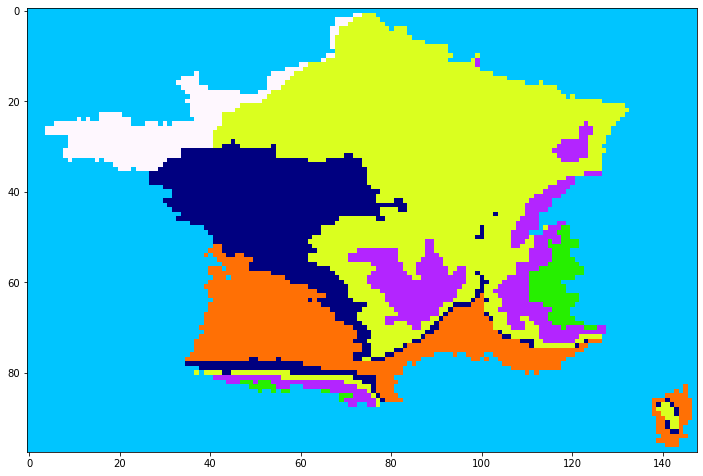

In [20]:
plt.figure(figsize=[12,12])
# cmap = plt.cm.terrain
# cmap = plt.cm.brg
# cmap = plt.cm.gist_earth
cmap = plt.cm.gist_ncar
# cmap = plt.cm.gnuplot
plt.imshow(img_cl[:, :], cmap = cmap)
plt.show()

# SAVE

In [36]:
dataset = rasterio.open(
    'france_climat.tif',
    'w',
    driver    = 'GTiff',
    height    = img_cl.shape[0],
    width     = img_cl.shape[1],
    count     = 1,
    dtype     = img_cl.dtype,
    crs       = "EPSG:4326",
    transform = t2m_transform
)

dataset.write(img_cl, 1)
dataset.close()